# SYNESTHETIZER

Paint a picture out of music

https://en.wikipedia.org/wiki/Chromesthesia

## Grab the notes 

Sauce - https://github.com/ianvonseggern1/note-prediction

In [177]:
#audio_file = "VMM Recorder Song 7 Twinkle Twinkle Little Star.mp3"
audio_file = "Kanakana Mix 1.2.mp3"

In [2]:
#!pip3 install pydub
#!pip3 install matplotlib
#!pip3 install python-Levenshtein
#!pip3 install opencv-python

import argparse

from pydub import AudioSegment
import pydub.scipy_effects
import numpy as np
import scipy
import matplotlib.pyplot as plt

from utils import (
    frequency_spectrum,
    calculate_distance,
    classify_note_attempt_1,
    classify_note_attempt_2,
    classify_note_attempt_3,
)

In [3]:
def main(file, note_file, note_starts_file=None, plot_starts=False, plot_fft_indices=[]):
    # If a note file and/or actual start times are supplied read them in
    actual_starts = []
    if note_starts_file:
        with open(note_starts_file) as f:
            for line in f:
                actual_starts.append(float(line.strip()))

    actual_notes = []
    if note_file:
        with open(note_file) as f:
            for line in f:
                actual_notes.append(line.strip())

    song = AudioSegment.from_file(file)
    song = song.high_pass_filter(80, order=4)

    starts = predict_note_starts(song, plot_starts, actual_starts)

    predicted_notes = predict_notes(song, starts, actual_notes, plot_fft_indices)

    print("")
    if actual_notes:
        print("Actual Notes")
        print(actual_notes)
    #print("Predicted Notes")
    #print(predicted_notes)
    return predicted_notes

    if actual_notes:
        lev_distance = calculate_distance(predicted_notes, actual_notes)
        print("Levenshtein distance: {}/{}".format(lev_distance, len(actual_notes)))

In [4]:
def predict_note_starts(song, plot, actual_starts):
    # Size of segments to break song into for volume calculations
    SEGMENT_MS = 50
    # Minimum volume necessary to be considered a note
    VOLUME_THRESHOLD = -35
    # The increase from one sample to the next required to be considered a note
    EDGE_THRESHOLD = 5
    # Throw out any additional notes found in this window
    MIN_MS_BETWEEN = 100

    # Filter out lower frequencies to reduce noise
    song = song.high_pass_filter(80, order=4)
    # dBFS is decibels relative to the maximum possible loudness
    volume = [segment.dBFS for segment in song[::SEGMENT_MS]]

    predicted_starts = []
    for i in range(1, len(volume)):
        if volume[i] > VOLUME_THRESHOLD and volume[i] - volume[i - 1] > EDGE_THRESHOLD:
            ms = i * SEGMENT_MS
            # Ignore any too close together
            if len(predicted_starts) == 0 or ms - predicted_starts[-1] >= MIN_MS_BETWEEN:
                predicted_starts.append(ms)

    # If actual note start times are provided print a comparison
    if len(actual_starts) > 0:
        print("Approximate actual note start times ({})".format(len(actual_starts)))
        print(" ".join(["{:5.2f}".format(s) for s in actual_starts]))
        print("Predicted note start times ({})".format(len(predicted_starts)))
        print(" ".join(["{:5.2f}".format(ms / 1000) for ms in predicted_starts]))

    # Plot the volume over time (sec)
    if plot:
        x_axis = np.arange(len(volume)) * (SEGMENT_MS / 1000)
        plt.plot(x_axis, volume)

        # Add vertical lines for predicted note starts and actual note starts
        for s in actual_starts:
            plt.axvline(x=s, color="r", linewidth=0.5, linestyle="-")
        for ms in predicted_starts:
            plt.axvline(x=(ms / 1000), color="g", linewidth=0.5, linestyle=":")

        plt.show()

    return predicted_starts

In [5]:
def predict_notes(song, starts, actual_notes, plot_fft_indices):
    predicted_notes = []
    for i, start in enumerate(starts):
        sample_from = start + 50
        sample_to = start + 550
        if i < len(starts) - 1:
            sample_to = min(starts[i + 1], sample_to)
        segment = song[sample_from:sample_to]
        freqs, freq_magnitudes = frequency_spectrum(segment)

        predicted = classify_note_attempt_1(freqs, freq_magnitudes)
        predicted_notes.append(predicted or "U")

        # Print general info
        print("")
        print("Note: {}".format(i))
        if i < len(actual_notes):
            print("Predicted: {} Actual: {}".format(predicted, actual_notes[i]))
        else:
            print("Predicted: {}".format(predicted))
        print("Predicted start: {}".format(start))
        length = sample_to - sample_from
        print("Sampled from {} to {} ({} ms)".format(sample_from, sample_to, length))
        print("Frequency sample period: {}hz".format(freqs[1]))

        # Print peak info
        peak_indicies, props = scipy.signal.find_peaks(freq_magnitudes, height=0.015)
        print("Peaks of more than 1.5 percent of total frequency contribution:")
        for j, peak in enumerate(peak_indicies):
            freq = freqs[peak]
            magnitude = props["peak_heights"][j]
            print("{:.1f}hz with magnitude {:.3f}".format(freq, magnitude))

        if i in plot_fft_indices:
            plt.plot(freqs, freq_magnitudes, "b")
            plt.xlabel("Freq (Hz)")
            plt.ylabel("|X(freq)|")
            plt.show()
    return predicted_notes

### Time to get note-y

In [178]:
notes = main(audio_file, note_file="output.txt")

frequency 95.0
magnitude 0.022005530969202824

Note: 0
Predicted: None
Predicted start: 4000
Sampled from 4050 to 4550 (500 ms)
Frequency sample period: 1.0hz
Peaks of more than 1.5 percent of total frequency contribution:
95.0hz with magnitude 0.022
frequency 52.0
magnitude 0.019338710155215332

Note: 1
Predicted: G#
Predicted start: 16800
Sampled from 16850 to 17350 (500 ms)
Frequency sample period: 1.0hz
Peaks of more than 1.5 percent of total frequency contribution:
52.0hz with magnitude 0.019
79.0hz with magnitude 0.017
98.0hz with magnitude 0.016
frequency 54.0
magnitude 0.017462165970811367

Note: 2
Predicted: A
Predicted start: 29600
Sampled from 29650 to 30150 (500 ms)
Frequency sample period: 1.0hz
Peaks of more than 1.5 percent of total frequency contribution:
54.0hz with magnitude 0.017
frequency 95.0
magnitude 0.022747049919791318

Note: 3
Predicted: None
Predicted start: 42400
Sampled from 42450 to 42950 (500 ms)
Frequency sample period: 1.0hz
Peaks of more than 1.5 perce

In [179]:
notes = [i for i in notes if i != 'U'] 
notes

['G#',
 'A',
 'D',
 'C#',
 'C',
 'F',
 'D',
 'E',
 'E',
 'D',
 'E',
 'C#',
 'G#',
 'G#',
 'F#',
 'G#',
 'D',
 'D',
 'D',
 'C#',
 'F#',
 'C#',
 'C#',
 'G',
 'G',
 'G',
 'G',
 'G#',
 'G',
 'C',
 'D',
 'G',
 'G',
 'D',
 'D',
 'C#',
 'C#',
 'F#',
 'C',
 'A',
 'G',
 'F#',
 'C',
 'C',
 'G',
 'A#',
 'A#',
 'C#',
 'C#',
 'C',
 'A#',
 'G#',
 'A',
 'C',
 'B',
 'G#',
 'C',
 'D',
 'D',
 'A#']

### Clean up the notes - Remove any erroneous notes

In [205]:
#Define Percentage Threshold for errors - If the frequency of occurence of any notes are less than 
#<percentThresh>%, they will be removed

percentThresh = 10

In [206]:
def CountFrequency(my_list): 
  
    # Creating an empty dictionary  
    freq = {} 
    for item in my_list: 
        if (item in freq): 
            freq[item] += 1
        else: 
            freq[item] = 1
  
    return freq

In [207]:
freqDict = CountFrequency(notes)
freqDict

{'G#': 7,
 'A': 3,
 'D': 11,
 'C#': 9,
 'C': 8,
 'F': 1,
 'E': 3,
 'F#': 4,
 'G': 9,
 'A#': 4,
 'B': 1}

In [208]:
threshold = sum(freqDict.values())/percentThresh
threshold

6.0

In [209]:
removeList = []
for key,value in freqDict.items():
    if value < threshold:
        removeList.append(key)
        
removeList

['A', 'F', 'E', 'F#', 'A#', 'B']

In [210]:
cleanNotes = [i for i in notes if i not in removeList]
#cleanNotes

## Generating a Painting

Possible Approaches: 

1. Easy - Generate color grid, create painting out of the grid
2. Hard - Grab the color palette, create painting out of the color palette

In [34]:
import cv2

In [14]:
scriabinDict = {"C":"#ff0000", "C#": "#cf9bff", "D": "#ffff00", "D#":"#65659a", "E": "#e4fbff", "F": "#ae1600", "F#": "#00cdff", "G": "#ff6500", "G#": "#ff00ff", "A": "#30cd30", "A#": "#8d8b8d", "B": "#0000fe"}
#scriabinDict

In [211]:
hexList = []

for note in cleanNotes:
    for notekey, notehex in scriabinDict.items():
        if note == notekey:
            hexList.append(notehex)
            
#hexList

In [212]:
def findBestFactorPair(n): 
    newdiff = 10000
    for i in range(1, int(pow(n, 1 / 2))+1): 
        if n % i == 0: 
            if ((n/i)-i)<newdiff:
                xfact = i
                yfact = n/i
    return xfact,int(yfact)

In [213]:
if len(hexList)%2 != 0:
    hexList.pop()

xfact,yfact = findBestFactorPair(len(hexList))

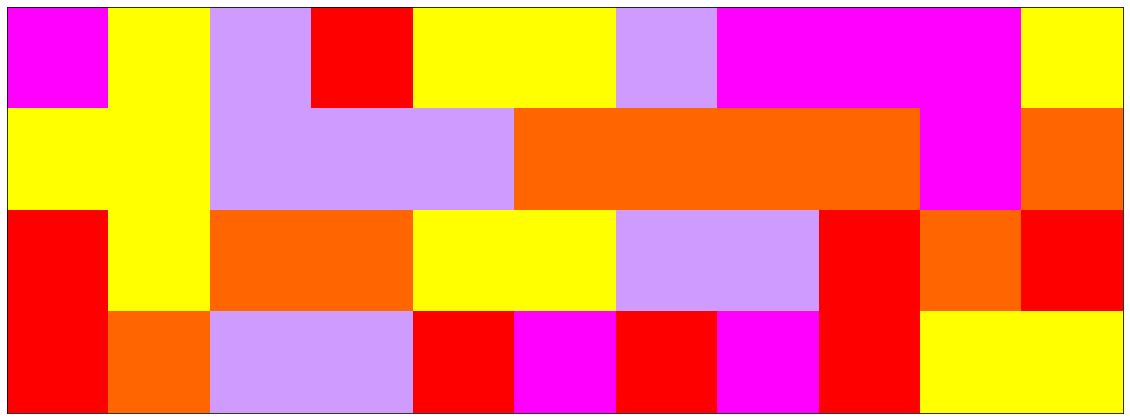

In [216]:
from matplotlib.colors import to_rgba_array

plt.figure(figsize=(20, 10))

plt.tick_params(left=False,
                bottom=False,
                labelleft=False,
                labelbottom=False)

plt.imshow(to_rgba_array(hexList).reshape(xfact,yfact,4))

plt.savefig('Grid.png', bbox_inches='tight')

In [217]:
img = cv2.imread('Grid.png')

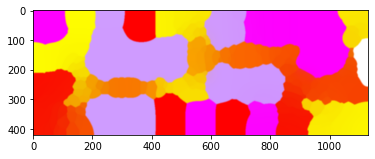

In [218]:
res = img

for i in range(5):
    res = cv2.xphoto.oilPainting(res, 7, 1)
    res = cv2.stylization(res, sigma_s=60, sigma_r=0.6)
    res = cv2.xphoto.oilPainting(res, 7, 1)
    res = cv2.blur(res,(5,5))
  
#Smoothening pass
for i in range(20):
    res = cv2.xphoto.oilPainting(res, 7, 1)
    res = cv2.blur(res,(5,5))
        
plt.imshow(cv2.cvtColor(res, cv2.COLOR_BGR2RGB))

In [219]:
cv2.imwrite("outimg.png", res)

True